## From Kaplan 

In [1]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import slippy2 as sp
from slippy2 import unit_conversions
from slippy2 import boundary_layer2d



from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [2]:
############
#Model name.  
############
Model = "T"
ModNum = 14

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [3]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early 

In [4]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        

results/T/11/Base/checkpoint/ is empty


In [5]:
###########
#Physical parameters
###########

#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e20,
           'k':10**-6,
           'a':3e-5, 
           'deltaT':1400,
           'TS':273,
           'TB':1673,
           #'cohesion':5e6,
           'cohesion':50e6,
           #'fc':0.03,
           'fc':0.06,
           'E':1e5, 
           'StALS': 27.*1e3})

#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
           'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) })

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT *(dp.LS)**3)/(dp.k*dp.eta0),
           'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'TS':0.,
            'TB':1.,
            'low_visc':1e-4,
            'StAeta0':0.1,
            'up_visc':1e5,
            'H':0.})

In [6]:
#These would be the values in the 700 km deep model of Kaplan
#ndp.cohesion = 21779.999
#ndp.RA = 3908985.36
ndp.RA

328190318.91954

In [7]:
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
#RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
RCA = (1650.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT_AIR = RCA/ndp.RA
#RCC = (100.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for crust
#COMP_RA_FACT_CRUST = RCC/ndp.RA
#RCE = -1*(200.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for eclogite 
#COMP_RA_FACT_ECL = RCE/ndp.RA
ndp["StA_RA"] = ndp.RA*COMP_RA_FACT_AIR

In [8]:
#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (900.*1e3)/dp.LS 
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TB #Used to define lithosphere

In [9]:
###########
#Boundary layer / slab paramaters
###########

subzone = -0.35
mor = 0.6
vel = 70e3
agelimit = 100.
thermallimit = 0.8

#Slab perturbation paramaters
Roc = 450.
Crust = 35.
theta = 89.


In [11]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -0.75
MINY = 0.
MAXX = 0.75

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 160


if MINX == 0.:
    Xres = RES
else:
    Xres = 256 #Hardcoding this fow now.


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [True, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = True


#System/Solver stuff

PIC_integration=True
ppc = 25

In [12]:
###########
#Model Runtime parameters
###########

swarm_update = 10
swarm_repop = 25
files_output = 1e6
gldbs_output = 25
images_output = 1e6
checkpoint_every = 25
metric_output = 25
sticky_air_temp = 10

comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
#assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
#assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'

In [13]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = elementType,
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [14]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [15]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(sp.find_closest(orgs, value_to_constrain), np.array([1.,0]))]


In [16]:
#Y-Axis
if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.6001
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    sp.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(128, 0.0046882812499999997, 0.84814687499999974, 0.61219527559055276)
('edges', 128)
-- iteration 0 --
| F( p_n ) |^2: 1.98289105657e-05
| p_n+1 - p_n |^2: 0.693112959188
-- iteration 1 --
| F( p_n ) |^2: 7.64543030408e-31
Min, Max element width: 
0.00469
0.01094


In [17]:
subzone

-0.35

In [18]:
lith= boundary_layer2d.LithosphereTemps(mesh, temperatureField, dp.LS, subzone , mor, tint=ndp.TB, tsurf=ndp.TS, vel= 10e3, diffs = 1e-6)


In [19]:
#import matplotlib.pyplot as pyplot
#%matplotlib inline
#xs = np.linspace(MINX, MAXX, 100)
#ages = [lith.agefunc(x) for x in xs]
#pyplot.plot(xs, ages)

In [20]:
fudge = 1.

for index, coord in enumerate(mesh.data):
    xloc = coord[0]
    agema = lith.agefunc(xloc)
    #print agema
    if agelimit:
        agema = min(agelimit, agema)
        
    if  coord[0] > mor or coord[0] < subzone: # Hacky implementation of asymmetry in spreading rate
        agema = agema/2.
    if thermallimit:
        if (1.-coord[1]) < (lith.lithdepthfunc(agema)/dp.LS)*thermallimit: #comparison of dimensionless (model) lengths
            zloc = ((1.- coord[1])* dp.LS) # dimensional depth kms
            t = lith.tempfunc(agema,  zloc)
            temperatureField.data[index] = t
        else:
            temperatureField.data[index] = lith.tint
    
    else:
        if coord[1] >= 1.:
            temperatureField.data[index] = lith.tsurf
        else:
            zloc = ((1.- coord[1])* dp.LS) # dimensional depth kms
            t = lith.tempfunc(agema, zloc)
            temperatureField.data[index] = t  

In [21]:
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

#Setup slab perturbation params (mostly dimensionles / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)*1e3
CrustM = MANTLETOCRUST
#slabdepth = lithdepthfunc(agefunc(off, off, vel), dp.k)
slabdepthM = lith.lithdepthfunc(lith.agefunc(subzone)) /dp.LS
#slabdepthM *= 5.
Org = (0.+subzone, 1.-RocM)
#Use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , RocM)
Gc = inCircleFnGenerator(Org , RocM + (50e3/dp.LS)) #a slightly larger circle for the 'gap'
Ic = inCircleFnGenerator(Org , RocM - slabdepthM)
Cc = inCircleFnGenerator(Org , RocM - CrustM)
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

#Work our which way the slab should face:
sense = 'Left'
#if lith.agefunc(subzone + 0.0001) < lith.agefunc(subzone - 0.0001):
#    sense = 'Right'

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left': 
    ptx = subzone - dx
else:
    ptx = subzone + dx

coords = ((0.+subzone, 1), (0.+subzone, 1.-RocM), (ptx, 1.))
Tri = fn.shape.Polygon(np.array(coords))

In [22]:
#Assign temperatures in the perturbation region
#sds = []
if sense == 'Left': 
    age = lith.agefunc(subzone + 0.001)
else:
    age = lith.agefunc(subzone - 0.001)
    
if agelimit:
        age = min(agelimit, age)
                

for index, coord in enumerate(mesh.data):
    #if Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Ic.evaluate(tuple(coord)): #in inner circle, not in outer circle
    if Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)): #In the quarter-circle defining the lithosphere
  
        sd = ((RocM - math.sqrt((coord[0] - Org[0])**2 + (coord[1] - Org[1])**2))*dp.LS) #distance from slab edge in m
        #print sd
        if thermallimit:
            if sd < (lith.lithdepthfunc(age))*thermallimit: #comparison of dimensionless (model) lengths
                t = lith.tempfunc(age, sd)
                temperatureField.data[index] = t
        else:
            t = lith.tempfunc(age, sd)
            temperatureField.data[index] = t
    if Gc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Oc.evaluate(tuple(coord)):
        temperatureField.data[index] =  lith.tint


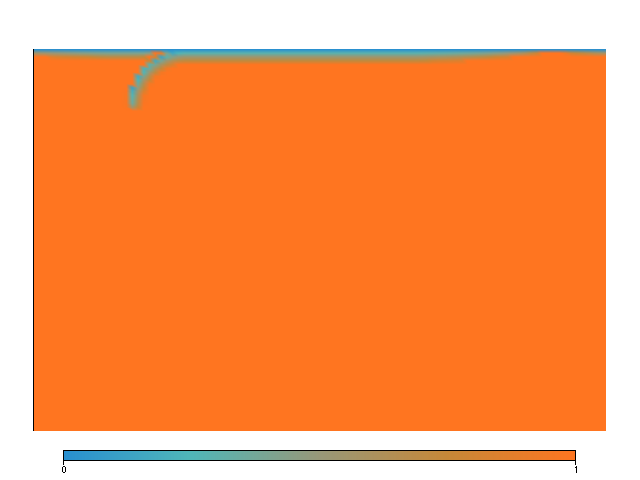

In [23]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField, discrete=True))

#figTemp.save_database('test.gldb')
figTemp.show()

In [24]:
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]

In [25]:
#Statiuonary node attempt for periodic BCs
#halfNum = (mesh.elementsGlobal/2)
#halfNum
#stationaryNode = uw.mesh.FeMesh_IndexSet(mesh, 2, halfNum + 1)
#stationaryNode.add(halfNum)

In [26]:
#Set Dirichlet Temp conditions

for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = lith.tint
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = lith.tsurf


# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(TWalls, JWalls) )

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )

# Particles

In [27]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )

In [28]:
mantleIndex = 0
lithosphereIndex = 1
eclIndex = 2
crustIndex = 3
airIndex = 4
tempIndex = 5




if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex


# Material Graphs

In [29]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3,4,5]


In [30]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='ecl')
DG.add_node(3, mat='crust')
DG.add_node(4, mat='air')
DG.add_node(5, mat='temp')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG)


#######Edges
#anything to air
DG.add_edges_from([(0,4),(1,4), (3,4)])
DG[0][4]['depthcondition'] = -1*TOPOHEIGHT
DG[1][4]['depthcondition'] = -1*TOPOHEIGHT
DG[3][4]['depthcondition'] = -1*TOPOHEIGHT


#Anything to mantle
DG.add_edges_from([(3,0), (1,0), (2,0), (5,0)])
DG[3][0]['depthcondition'] = CRUSTTOMANTLE #Normal crust
DG[1][0]['depthcondition'] = LITHTOMANTLE #This means we're going to kill lithosphere at the 660.
DG[2][0]['depthcondition'] = CRUSTTOMANTLE #Eclogite crust
DG[5][0]['depthcondition'] = CRUSTTOMANTLE #Normal crust

#Anything to lithsphere
DG.add_edges_from([(0,1),(4,1)])
DG[0][1]['depthcondition'] = MANTLETOLITH
DG[0][1]['avgtempcondition'] = 0.75*AVGTEMP #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,3), (1,3), (4,3)])
DG[0][3]['depthcondition'] = MANTLETOCRUST
DG[1][3]['depthcondition'] = MANTLETOCRUST
DG[4][3]['depthcondition'] = TOPOHEIGHT

#crust to eclogite
DG.add_edges_from([(3,2)])
DG[3][2]['depthcondition'] =CRUSTTOECL

In [31]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [32]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [33]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

In [34]:
#Set the crust material in the slab using shapes/function from uw.

if not checkpointLoad:
    #materialVariable.data[:] = mantleIndex
    #lithtemp = 0.95*0.8
    #tempswarm = temperatureField.evaluate(gSwarm)[:,0]

    #At this point, we only have to assign any materials that are defined by setup shapes,
    #the rest of the materials will be assigned using the materials graph

    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        coord = gSwarm.particleCoordinates.data[particleID]
        if gSwarm.particleCoordinates.data[particleID][1] > (1.0 - CrustM):
            materialVariable.data[particleID] =  crustIndex
        elif Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Cc.evaluate(tuple(coord)):
            #print("True")
            materialVariable.data[particleID] =  crustIndex
        if Gc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Oc.evaluate(tuple(coord)):
            materialVariable.data[particleID] =  tempIndex


In [35]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be traversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        check = update_swarm(DG, particleID)
        if check > -1:
            number_updated += 1
            materialVariable.data[particleID] = check


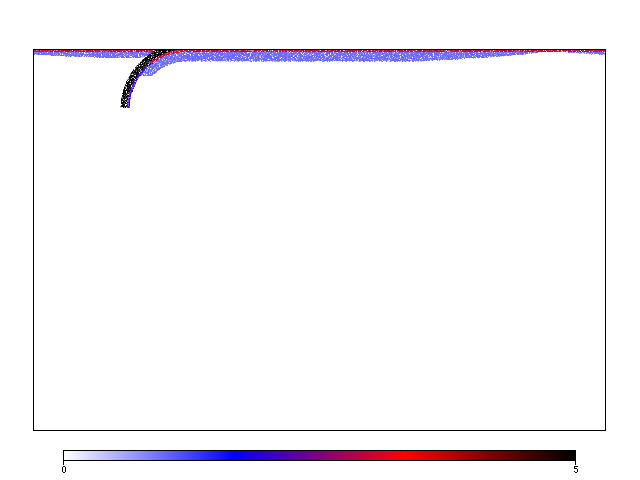

In [36]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='white blue red black'))
figMat.append( glucifer.objects.Mesh(mesh))
figMat.save_database('test.gldb')
figMat.show()

## Rheology

In [37]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


coordinate = fn.input()
depth = 1. - coordinate[1]


In [38]:
arhennius = fn.misc.min(ndp.up_visc, fn.math.exp(((-1.*math.log(dp.E)) + (math.log(dp.E) / (temperatureField + 1e-8)))))  


In [39]:
math.log(dp.E)

11.512925464970229

In [40]:
#Psuedo-plastic 
ys =  ndp.cohesion + (depth*ndp.fcd)
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)
#combine these
mantleviscosityFn = fn.misc.min(arhennius, plastic)

############
#crust
############



ysc = (ndp.cohesion/10.) + (depth*(ndp.fcd/100.))
#ysc = ys/100.
ycs = fn.misc.max((ndp.cohesion/10.), ysc)
crustplasticvisc = ycs*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc) 
crustviscosityFn = fn.misc.min(arhennius, crustplastic)

In [41]:
#figVisc = glucifer.Figure()
#figVisc.append( glucifer.objects.Surface(mesh, mantleviscosityFn, logScale=True))
#figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0002))
#figVisc.save_database('test.gldb')
#figVisc.show()

In [42]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:crustviscosityFn,
                                    mantleIndex:mantleviscosityFn, 
                                    eclIndex:crustviscosityFn,
                                    tempIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA_RA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField, 
                                    eclIndex:ndp.RA*temperatureField,
                                    tempIndex:ndp.RA*temperatureField, } )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

## Build Stokes system

In [43]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = arhennius, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)

In [44]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system
if not checkpointLoad:
    solver.solve()

In [45]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [46]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

#solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''

In [47]:
solver.solve(nonLinearIterate=True)

In [48]:
ndp.H

0.0

In [49]:
#Create advdiff system



#advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
#                                         phiDotField    = temperatureDotField, 
#                                         velocityField  = velocityField, 
#                                         fn_diffusivity = 1.0,
#                                         fn_sourceTerm = 0.,
#                                         conditions     = [tempBC,] )


advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = ndp.H,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [dirichTempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [50]:
pics = uw.swarm.PICIntegrationSwarm(gSwarm)

## Figures / gldbs etc

In [51]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

In [52]:
#figVisc = glucifer.Figure()
#figVisc.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))

#figVisc.show()

In [53]:
# Mapping the viscosity function to the mesh using MeshVariable_Projection

#meshVisc  = uw.mesh.MeshVariable( mesh, 1 )
#projectorStrainRate = uw.utils.MeshVariable_Projection( meshVisc, viscosityMapFn, swarm=gSwarm)
#projectorStrainRate.solve()



In [54]:
#pyplot.imshow(np.flipud(meshVisc.data.reshape(80 + 1, 128 + 1)), cmap='PuOr')
#pyplot.colorbar()

In [55]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
#figDb.append( glucifer.objects.Surface(mesh, meshVisc, logScale=True, colours='brown white blue') )

figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.00001))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))
#figDb.show()

In [56]:
figDb.save_database('test.gldb')

In [57]:
step = 0
realtime = 0.
timevals = [0.]

In [ ]:
# initialise timer for computation
startMain = time.clock()
# Perform steps#
while realtime < 0.2:
#while step < 25:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
    ################
    #Particle update
    ###############
    particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
    particletemps = temperatureField.evaluate(gSwarm)[:,0]
    conditionmap['depthcondition']['data'] = particledepths
    conditionmap['avgtempcondition']['data'] = particletemps
    if step % swarm_update == 0:
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        #update the particle location swarm ready for next comparison
        print "number of particles updated: " + str(number_updated)
        #print(earthtimeMy, incr, incr_count)
    

0.0
1.0
2.0
3.0
4.0


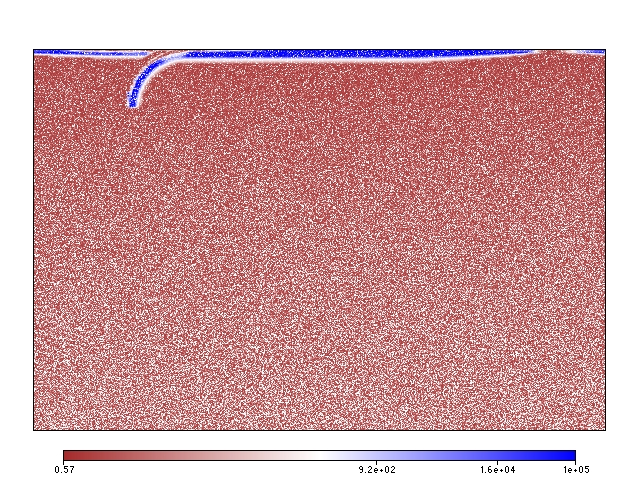

In [58]:
#Pack some stuff into a database as well
figVisc = glucifer.Figure()
figVisc.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figVisc.show()